In [1]:
import os
import struct
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import sys

%matplotlib inline

In [2]:
class channel(object):
    def __init__(self,edfFile,label=None,transducer=None,dimensions=None,
                physMin=None,physMax=None,digMin=None,digMax=None,
                 preFilter=None,sampleRate=None,notes=None,channelIndex=None,byteLength=None):
        self.edfFile = edfFile
        self.label = label
        self.sampleRate = sampleRate
        #self.indexStart = indexStart
        self.transducer = transducer
        self.dimensions = dimensions
        self.physMin = physMin
        self.physMax = physMax
        self.digMin = digMin
        self.digMax = digMax
        self.preFilter = preFilter
        self.notes  = notes
        self.channelIndex = channelIndex
        self.byteLength = byteLength
    
    def __str__(self):
        if self.label==None:
            return "None"
        else:
            return str(self.label) + " - "+str(self.channelIndex)
        
    def returnChannelData(self,start,duration,channelNumber):
        '''
        Returns data points for desired area
        start: seconds from start of record
        duration: time of record desired in seconds
        ##########This might be easier to do within original edf class
        '''
        toReturn = []
        seekLocation = int(self.channelIndex + start*2)
        numberOfBytes = int(self.sampleRate) * duration 
        self.edfFile.edfRawData.seek(seekLocation)
        for i in range(numberOfBytes):
            value = struct.unpack('h',self.edfFile.edfRawData.read(2))[0]
            #value -= channelNumber*256
            toReturn.append(value)
            #toReturn.append(struct.unpack('h',self.edfFile.edfRawData.read(2)))
            
        return toReturn
    
    def returnChannelDataForGraph(self,start,duration,channelNumber):
        '''
        Returns data points for desired area
        start: seconds from start of record
        duration: time of record desired in seconds
        ##########This might be easier to do within original edf class
        '''
        toReturn = []
        seekLocation = int(self.channelIndex + start*2)
        numberOfBytes = int(self.sampleRate) * duration 
        self.edfFile.edfRawData.seek(seekLocation)
        for i in range(numberOfBytes):
            value = struct.unpack('h',self.edfFile.edfRawData.read(2))[0]
            value -= channelNumber*256
            toReturn.append(value)
            #toReturn.append(struct.unpack('h',self.edfFile.edfRawData.read(2)))
            
        return toReturn
        
    def channelIndex(self):
        return self.channelIndex
    
    def returnLabel(self):
        return self.label
    
    def notes(self):
        return self.notes
    
    

In [3]:
class edfData(object):
    def __init__(self,fileId):
        self.fileId=fileId
        
    def __str__(self):
        return ("version: " + str(self.version) + "\nheader Bytes: " 
                + str(self.headerBytes) + "\nNum Records :" 
                + str(self.nRecords) + "\nNum Signals :" + str(self.nSignals) 
                + "\nFile Size: "+str(self.fileSize))
                
                
    def loadFile(self,filepath):
        self.filePath = filepath
        self.fileSize = os.path.getsize(filepath)
        self.edfRawData = open(filepath,'rb')
    
    def returnId(self):
        return self.fileId
        
    def printId(self):
        print("File Id: "+str(self.fileId))
   
    def printFileParams(self):
        print(("File Size: "+str(self.fileSize)))
        
    def readBitsTest(self):
        self.edfRawData.seek(0)
        bits = self.edfRawData.read(100000)
        #self.edfRawData.seek(0)
        #print(self.edfRawData.read(10))
        #print("Some Bits: "+str(bits))
        return bits
        
    def parseEdf(self):
        '''
            This function parses the edf file getting the values of 
            the header fields. It also creates a channel object with 
            information about each channel, including the eeg tracing data from each channel.
        '''
        #Header Fields
        self.version = self.edfRawData.read(8)
        self.patientId = self.edfRawData.read(80)
        self.recordId = self.edfRawData.read(80)
        self.startDate = self.edfRawData.read(8)
        self.startTime = self.edfRawData.read(8)
        self.headerBytes = int(self.edfRawData.read(8))
        self.reservedBytes = self.edfRawData.read(44)
        self.nRecords = int(self.edfRawData.read(8))
        self.duration = self.edfRawData.read(8)
        self.nSignals = int(self.edfRawData.read(4))
        
        #Create channel object for each channel
        self.channels = {}
        channelFields = ['labels','transducer','dimensions','physMin','physMax','digMin','digMax',
                        'preFilter','sampleRate','reservedNotes']
        self.channels['labels'] = self.edfRawData.read(self.nSignals*16).split()
        self.channels['transducer'] = self.edfRawData.read(self.nSignals*80).split()
        self.channels['dimensions'] = self.edfRawData.read(self.nSignals*8).split()
        self.channels['physMin'] = self.edfRawData.read(self.nSignals*8).split()
        self.channels['physMax'] = self.edfRawData.read(self.nSignals*8).split()
        self.channels['digMin'] = self.edfRawData.read(self.nSignals*8).split()
        self.channels['digMax'] = self.edfRawData.read(self.nSignals*8).split()
        self.channels['preFilter'] = self.edfRawData.read(self.nSignals*80).split()
        self.channels['sampleRate'] = self.edfRawData.read(self.nSignals*8).split()
        self.channels['reservedNotes'] = self.edfRawData.read(self.nSignals*32).split()
        
        self.channelObjects = []
        channelDataStart = self.headerBytes
        
        #This loop creates and add channel objects to self.channelObjects
        for i in range(int(self.nSignals)):
            
            channelValues ={'filepath':self.filePath}
            byteLength = int(self.channels['sampleRate'][i])*self.nRecords*i*2
            channelIndex = channelDataStart + byteLength
            
            for j in channelFields:
                try:
                    channelValues[j]=(self.channels[j][i])
                except:
                    channelValues[j] = None
            self.channelObjects.append(
                channel(self,channelValues['labels'],channelValues['transducer'],
                        channelValues['dimensions'],channelValues['physMin'],channelValues['physMax'],
                        channelValues['digMin'],channelValues['digMax'],channelValues['preFilter'],
                        channelValues['sampleRate'],channelValues['reservedNotes'],
                        channelIndex,byteLength))
            
    def returnDuration(self):
        return self.duration
    
    def returnNumSignals(self):
        return self.nSignals
            
    def returnData(self,start,duration):
        sampleData = []
        j=0
        for x in self.channelObjects:
            sampleData.append([x.returnLabel(),x.returnChannelData(start,duration,j)])
            j+=1
        return sampleData
    
    def returnDataForGraph(self,start,duration):
        sampleData = []
        j=0
        for x in self.channelObjects:
            sampleData.append([x.returnLabel(),x.returnChannelDataForGraph(start,duration,j)])
            j+=1
        return sampleData
    
    def returnSampleRate(self):
        return self.channels['sampleRate']   

In [6]:
print(edfFile1)

version: b'0       '
header Bytes: 8448
Num Records :20
Num Signals :32
File Size: 520448


In [17]:
edfFile1 = edfData(1)
edfFile1.loadFile("v1.2.0/eval/01_tcp_ar/00000258/s002_2003_07_21/00000258_s002_t000.edf")
edfFile1.parseEdf()

edfFile2 = edfData(1)
edfFile2.loadFile("v1.2.0/eval/01_tcp_ar/00001027/s003_2004_01_29/00001027_s003_t000.edf")
edfFile2.parseEdf()

print(edfFile2.returnSampleRate())
print(edfFile2.returnLabels())
print(edfFile2.returnDuration())
print(edfFile2.returnNumSignals())

[b'400', b'400', b'400', b'400', b'400', b'400', b'400', b'400', b'400', b'400', b'400', b'400', b'400', b'400', b'400', b'400', b'400', b'400', b'400', b'400', b'400', b'400', b'400', b'400', b'400', b'400', b'400', b'400', b'400', b'400', b'400', b'400']


AttributeError: 'edfData' object has no attribute 'returnDuration'

In [8]:


#print ("Buffer Bytes: "+str(sys.getsizeof(plotData)))

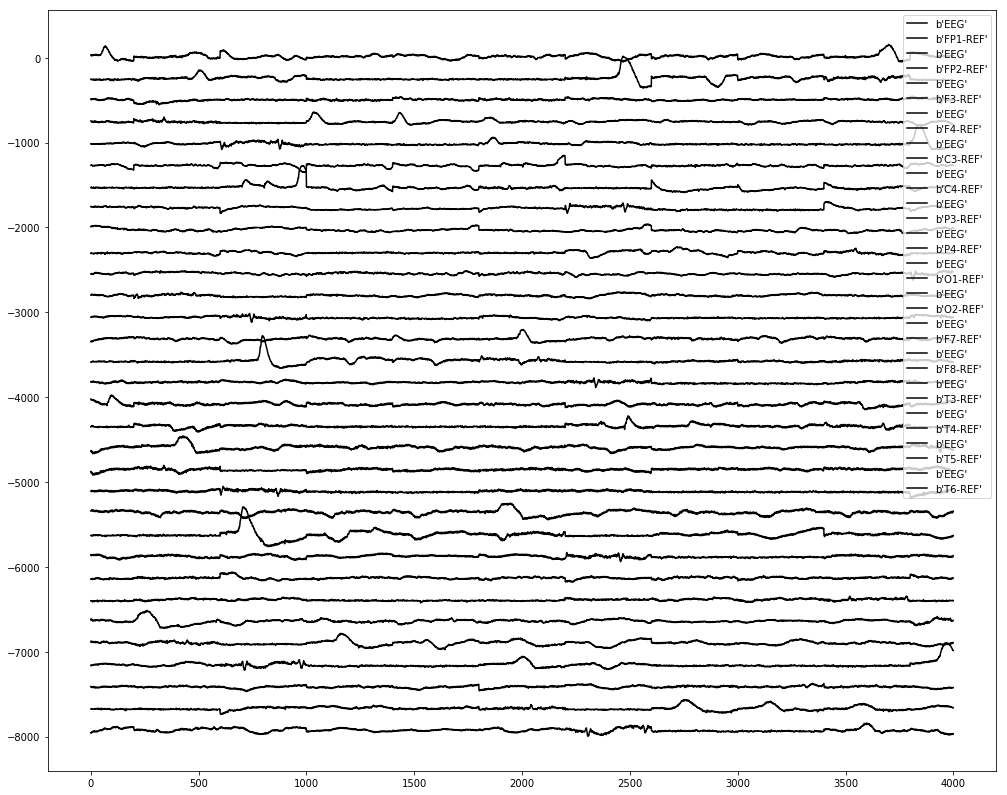

In [9]:
plotData = edfFile1.returnDataForGraph(600,10)
plt.figure(figsize=(17,14))
for x in plotData:
    plt.plot(x[1],color='black',label=x[0])
plt.legend()

In [16]:
channel1 = np.array(plotData2[5])
x = np.sin(channel1)
con1 = np.convolve(channel1,x)

ValueError: setting an array element with a sequence

b'F3-REF'


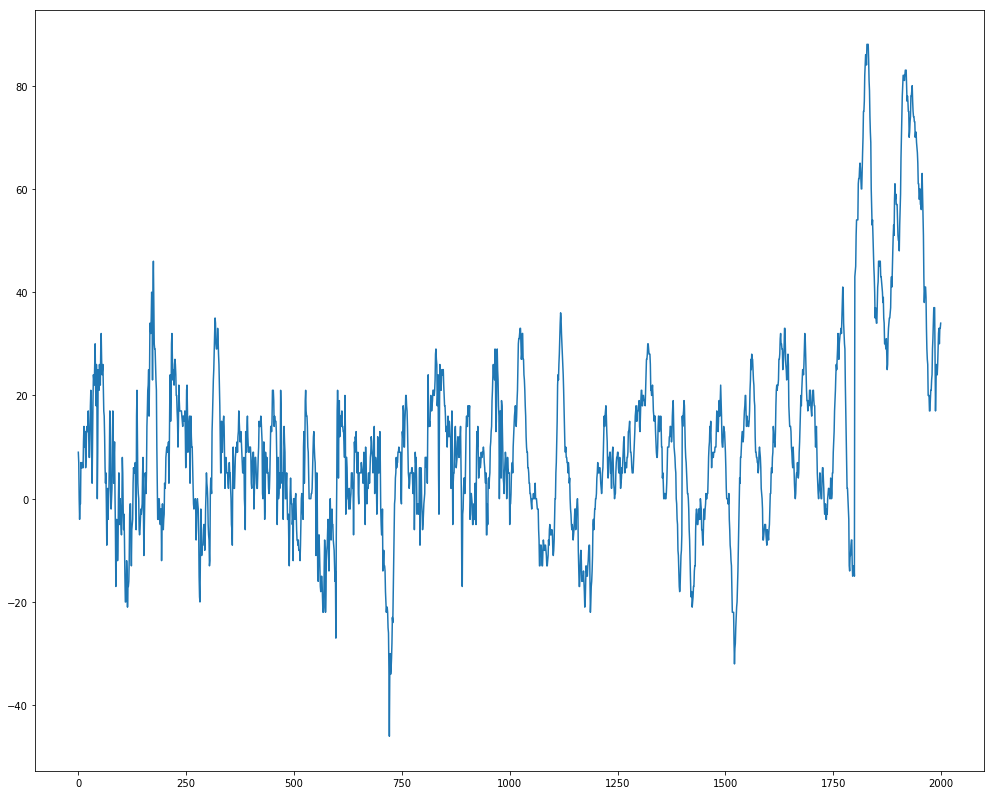

In [14]:
plotData2 = edfFile2.returnData(7000,5)
channel1 = plotData2[5]
plt.figure(figsize=(17,14))
plt.plot(channel1[1],label=channel1[0])
print (channel1[0])

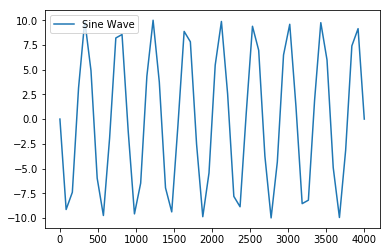

In [182]:
x = np.linspace(0,4000)
plt.plot(x, 10*np.sin(x*np.pi),label="Sine Wave")
plt.legend()

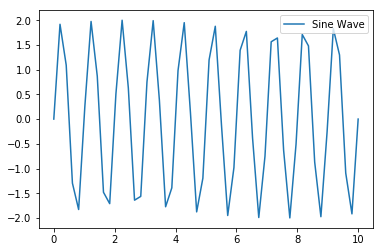

In [127]:
x = np.linspace(0,10)
plt.plot(x,2*np.sin(x*np.pi*2),label="Sine Wave")
plt.legend()